In [13]:
import matplotlib.pyplot as plt
import torchvision
from pathlib import Path
import torch

from torch import nn
from torchvision import transforms
from scripts import data_setup, engine, utils
import torchinfo

In [14]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [15]:
data_path = Path("data/")
image_path = data_path / "soil_low_med_high"

In [16]:
# Get a set of pretrained model weights
weights = torchvision.models.ResNeXt101_64X4D_Weights.DEFAULT
weights
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [17]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

In [18]:
#HyperParameters
batch_Size = 5
learning_rate = 0.001
epochS = 10
dropout_prob = 0.2

In [19]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=batch_Size)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x274f6ba1550>,
 ['high', 'low', 'medium'])

In [20]:
model = torchvision.models.resnext101_64x4d(weights=weights).to(device)

In [21]:
for param in model.parameters():
    param.requires_grad = False

In [22]:
# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = nn.Sequential(
    nn.Dropout(p=dropout_prob, inplace=True), 
    nn.Linear(in_features=9216, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [23]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [24]:

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=epochS,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:09<?, ?it/s]


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

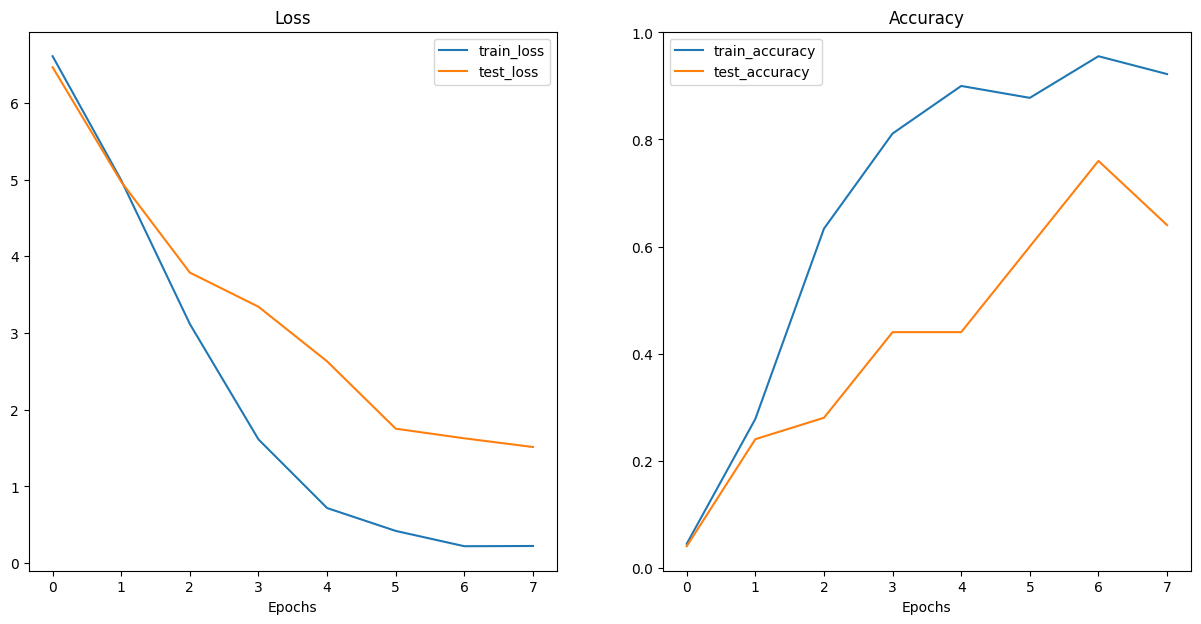

In [ ]:
from scripts.helper_functions import plot_loss_curves

plot_loss_curves(results)

In [ ]:
from winsound import Beep
Beep(300, 200)

In [ ]:
# utils.save_model(model=model,
#                  target_dir="models",
#                  model_name="vgg16_1.pth")

[INFO] Saving model to: models\vgg16_1.pth
